This is a really simple analysis of the loss experienced by subgroups relative to their centroid. I use a simple loss function to calculate how much loss each individual within a cluster experiences, and check how that loss might differ for subgroups using differences in their cumulative distribution functions.

In [ ]:
import pandas as pd
from geopy.distance import lonlat
import math
import os
import shapefile as shp
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from ipynb.fs.full.quad_loss_functions import calc_loss
from ipynb.fs.full.demog_functions import plot_shape, plot_map
import seaborn as sns

In [2]:
# kmeans centroids were generated separately so we'll just read in the locations of those centroids from that analysis and base ours on those values
# eventually, we'll want to do this dynamically

# also going to collect the x- and y- coordinates of covered points to visualize and check them
x_coords = []
y_coords = []

# ...as well as the corresponding cendroids
x_center = []
y_center = []
    
# finally, we want to extract and store both the race and loss data
race = []
loss = []
    
# change 'test' to 'k_100_membership' when ready
path = 'kmeans_centroids/k_100_membership/' # each cluster's membership is stored in a separate file so we need to go through each to extract the data

for i in os.listdir(path):
    data = pd.read_csv(path+i,names=['race','x','y'],dtype={'race':np.str,'x':np.float64,'y':np.float64})
    

    # extract centroid info
    x_ref = data.x[0]
    y_ref = data.y[0]
    
    x_center.append(x_ref) # add to the centroid list
    y_center.append(y_ref)

    # want to calculate the loss of each individual relative to the centroid        
    i=1

    while i < len(data):
        x = data['x'][i] # grab the x- & y-coordinates & race from the table
        y = data['y'][i]
        r = data['race'][i]
        l = calc_loss(x,y,x_ref,y_ref)
        
        x_coords.append(x)
        y_coords.append(y)
        race.append(r)
        loss.append(l)
        
        i+=1
        
    del(data)
    

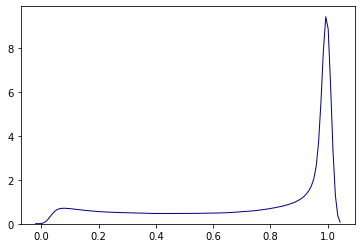

In [3]:
sns.distplot(loss, hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

In [4]:
# find the population-level proportions for each race
types = list(set(race))
pop_race = dict.fromkeys(types,0)

for r in race:
    pop_race[r]+=1
    
total = len(race)
pop_race = {k: v/total for k, v in pop_race.items()}

In [ ]:
# in the first iteration of this we want to simplify: 
# - select 2 subgroups for comparison 
# - select percentile at which to compare

In [150]:
def compare_loss(group1,group2,percentile):
    select_race = [group1, group2]
    
    percentile_loss = []
    for s in select_race:
        subgroup = [l for l,r in zip(loss,race) if r==s] # subset the two different groups of interest
        loss_p = np.percentile(subgroup, percentile,interpolation='linear') # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss
        
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    
    return difference

0.10013106745534084

In [152]:
test = compare_loss('white','black',25)
test

0.11680661591582353

In [155]:
test_diff = []
for i in range(100):
    diff = compare_loss('white','black',i+1)
    test_diff.append(diff)
test_diff

[0.002689941607631967,
 0.004994351036907728,
 0.007602462856273737,
 0.010857350625191234,
 0.014408512730845757,
 0.0189424256411998,
 0.023326277826906022,
 0.02789072159785494,
 0.03309164406959744,
 0.038307043567858134,
 0.044085675254267626,
 0.049960767633818404,
 0.055665311766864345,
 0.06194232221149154,
 0.06815569754622902,
 0.07477972912869374,
 0.08112849822669194,
 0.0875080646210944,
 0.09307833957828932,
 0.09851411076051991,
 0.10329845976944335,
 0.1073166633138487,
 0.11155858535375296,
 0.11470624545705188,
 0.11680661591582353,
 0.11841550606287599,
 0.11936901249004417,
 0.11996616283212058,
 0.11960857336569464,
 0.11800864661699384,
 0.11559714164962487,
 0.112749937482855,
 0.10915145342186272,
 0.1048928940324475,
 0.10013106745534084,
 0.09509803322827859,
 0.09005373988796495,
 0.08481730386511965,
 0.07946532998598255,
 0.07430727028735551,
 0.06912486427088504,
 0.06432738837160745,
 0.05961204575179346,
 0.05473832944837209,
 0.05014808706937346,
 0.045

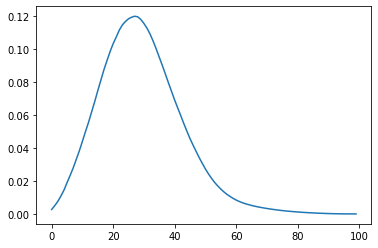

In [157]:
plt.plot(test_diff)

In [196]:
# Now we want to scan over all percentiles for the two gorups looking for the biggest difference between the two

def scan_compare_loss(group1,group2):
    select_race = [group1, group2]
    
    difference = []
    for i in range(len(select_race)):
        subgroup = [l for l,r in zip(loss,race) if r==select_race[i]] # subset the two different groups of interest
        for p in range(1,100):
            loss_p = np.percentile(subgroup, p,interpolation='linear') # find the level of loss at given percentile
            if i==0:
                difference.append(loss_p) # load list with loss
            else:
                difference[p-1] = difference[p-1] - loss_p
    
    # pull out the maximum difference within percentile
    max_diff = max(difference)
    return max_diff


In [197]:
scan_compare_loss('white','black')

0.11996616283212058